# MONAI Ditigal Pathology

## Nuclear segmentation and classification with HoVerNet (CoNSeP)

A multiple branch network that performs nuclear instance segmentation and classification within a single network. The network leverages the horizontal and vertical distances of nuclear pixels to their centres of mass to separate clustered cells. A dedicated up-sampling branch is used to classify the nuclear type for each segmented instance. <br >

[Link](https://www.sciencedirect.com/science/article/abs/pii/S1361841519301045?via%3Dihub) to Medical Image Analysis paper. <b /
[github ](
https://github.com/vqdang/hover_net) his is the official PyTorch implementation of HoVer-Net. For the original TensorFlow version of this code, please refer to [this branch](https://github.com/vqdang/hover_net/tree/tensorflow-final). The repository can be used for training HoVer-Net and to process image tiles or whole-slide ima

They, we supply model weights trained on the following datasets:

- [CoNSeP](https://www.sciencedirect.com/science/article/pii/S1361841519301045)
- [PanNuke](https://arxiv.org/abs/2003.10778)
- [MoNuSAC](https://ieeexplore.ieee.org/abstract/document/8880654)
- [Kumar](https://ieeexplore.ieee.org/abstract/document/7872382)
- [CPM17](https://www.frontiersin.org/articles/10.3389/fbioe.2019.000ptg/hover_net)




![diagram](https://github.com/vqdang/hover_net/raw/master/docs/diagram.png)

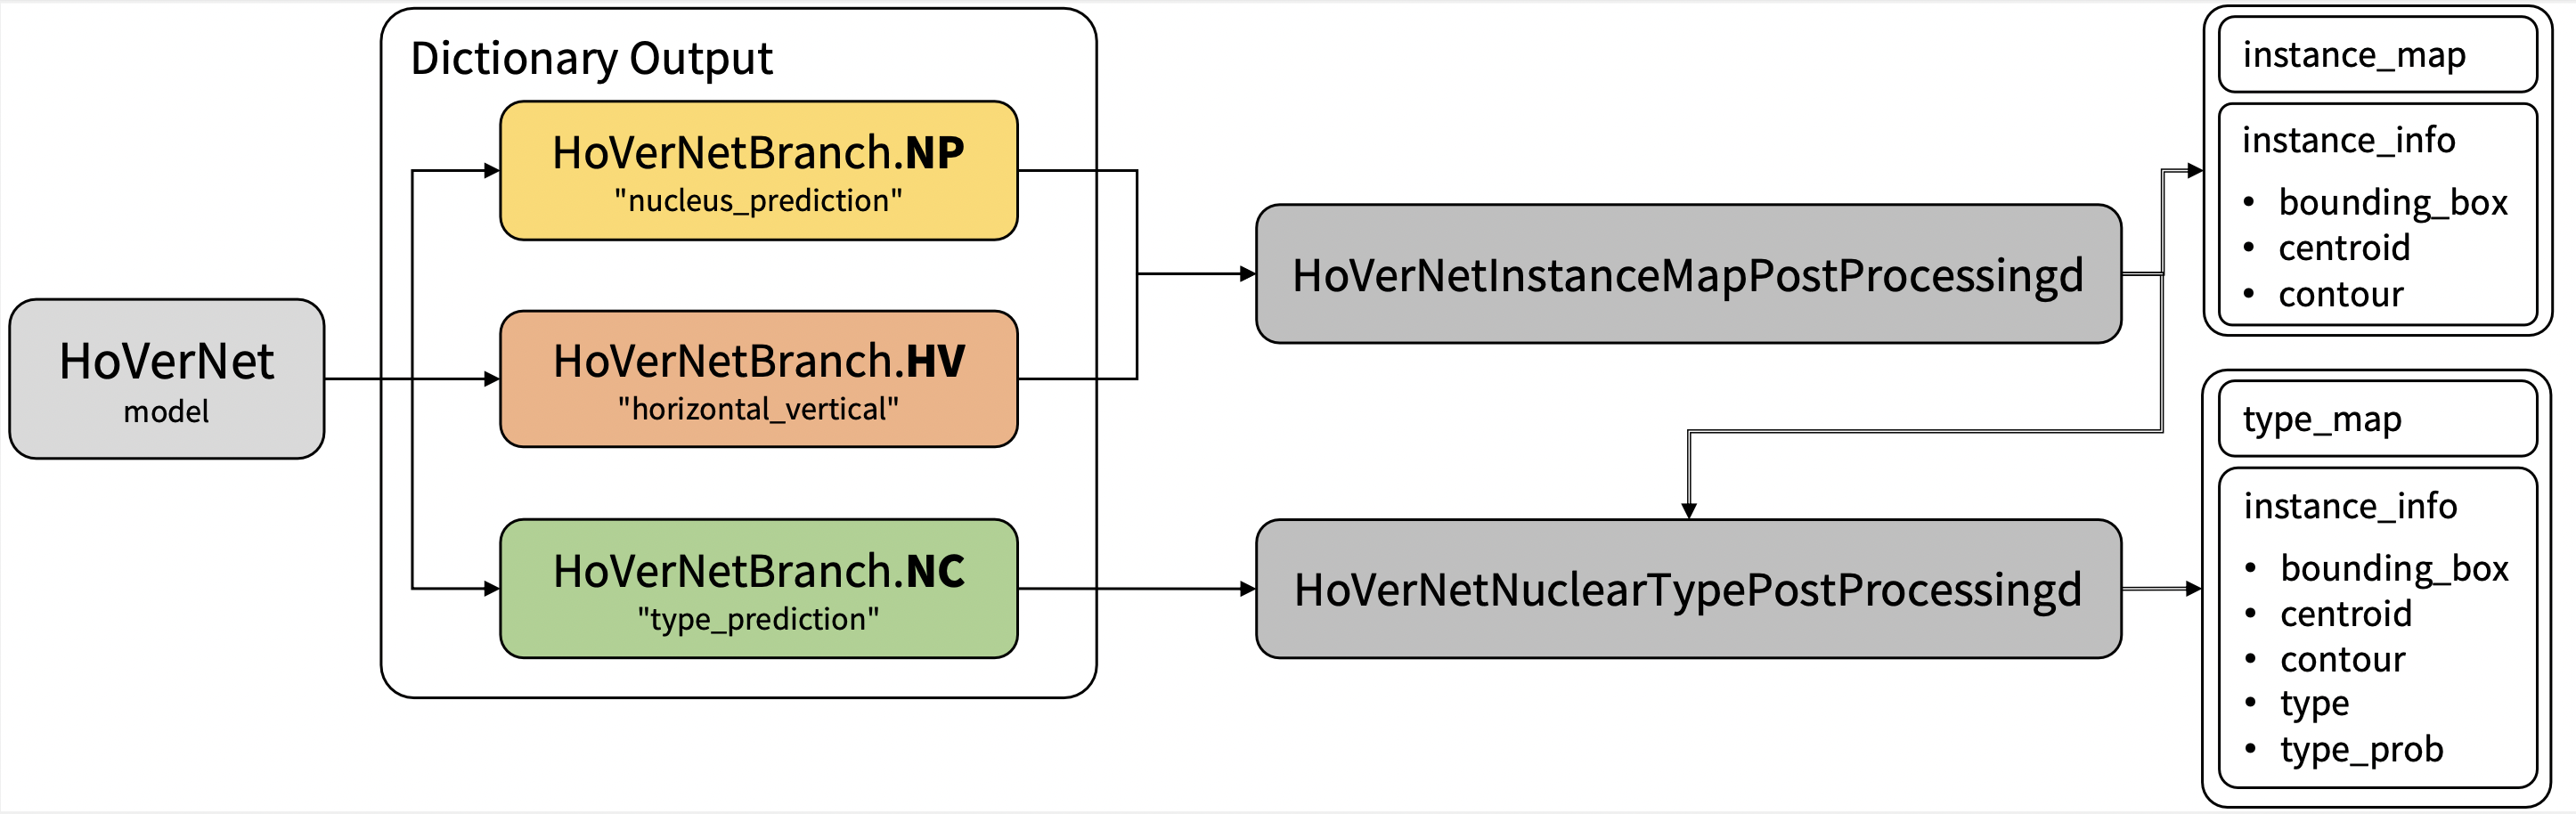


In [1]:
!pwd

/workspace/notebook_monai


In [2]:
import monai
from monai.config import print_config

print_config()

MONAI version: 1.3.dev2334
Numpy version: 1.22.2
Pytorch version: 1.14.0a0+44dac51
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: c5771c7316c8b024071ecd7135d77ae70bcd557e
MONAI __file__: /usr/local/lib/python3.8/dist-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: 0.4.11
ITK version: 5.3.0
Nibabel version: 5.1.0
scikit-image version: 0.21.0
scipy version: 1.10.1
Pillow version: 9.2.0
Tensorboard version: 2.9.0
gdown version: 4.7.1
TorchVision version: 0.15.0a0
tqdm version: 4.64.1
lmdb version: 1.4.1
psutil version: 5.9.4
pandas version: 1.5.2
einops version: 0.6.1
transformers version: 4.21.3
mlflow version: 2.6.0
pynrrd version: 1.0.0
clearml version: 1.12.2

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



Environment variable `TORCH_ALLOW_TF32_CUBLAS_OVERRIDE = 1` is set.
  This environment variable may enable TF32 mode accidentally and affect precision.
  See https://docs.monai.io/en/latest/precision_accelerating.html#precision-and-accelerating


### Setup imports

In [3]:
import os
import glob
import shutil
import tempfile
import time
import torch
import numpy as np
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

In [4]:

from monai.data import DataLoader, decollate_batch, CacheDataset, Dataset
from monai.apps import download_and_extract
from monai.networks.nets import HoVerNet
from monai.metrics import DiceMetric
from monai.transforms import (
    LoadImaged,
    EnsureChannelFirstd,
    TorchVisiond,
    Lambdad,
    Activations,
    OneOf,
    MedianSmoothd,
    AsDiscrete,
    AsDiscreted,
    Compose,
    CastToTyped,
    ComputeHoVerMapsd,
    ScaleIntensityRanged,
    RandGaussianNoised,
    RandFlipd,
    RandAffined,
    RandGaussianSmoothd,
    CenterSpatialCropd,
)
from monai.apps.pathology.transforms import HoVerNetInstanceMapPostProcessingd, HoVerNetNuclearTypePostProcessingd
from monai.apps.pathology.losses.hovernet_loss import HoVerNetLoss
from monai.apps.pathology.inferers import SlidingWindowHoVerNetInferer

from monai.transforms.utils import apply_transform
from monai.utils import set_determinism, first
from monai.utils.enums import HoVerNetBranch
from monai.visualize import plot_2d_or_3d_image
from skimage import measure
from torch.cuda.amp import GradScaler, autocast


## Environment
DATA Cache Directory

In [5]:
!pwd

/workspace/notebook_monai


In [6]:
%env MONAI_DATA_DIRECTORY=/workspace/notebook_monai/dataset_hovernet/

env: MONAI_DATA_DIRECTORY=/workspace/notebook_monai/dataset_hovernet/


In [7]:
directory = os.environ.get("MONAI_DATA_DIRECTORY")
root_dir = tempfile.mkdtemp() if directory is None else directory
print(root_dir)

/workspace/notebook_monai/dataset_hovernet/


In [8]:
from monai.apps import download_and_extract
from monai.transforms.utils import apply_transform
from monai.utils import set_determinism, first

In [9]:
set_determinism(seed=24)

###  CoNSeP dataset. 
![](https://production-media.paperswithcode.com/datasets/Screenshot_2021-01-27_at_16.05.33.png)

The colorectal nuclear segmentation and phenotypes (CoNSeP) dataset consists of 41 H&E stained image tiles, each of size 1,000×1,000 pixels at 40× objective magnification. The images were extracted from 16 colorectal adenocarcinoma (CRA) WSIs, each belonging to an individual patient, and scanned with an Omnyx VL120 scanner within the department of pathology at University Hospitals Coventry and Warwickshire, UK.

- original data : 1000x1000 pixels
- Train dataset : 27
- Test dataset  : 14


The colour of the nuclear boundary denotes the type of nucleus.
- Blue: epithelial
- Red: inflammatory
- Green: spindle-shaped
- Cyan: miscellaneous


#### Download dataset, prepare patch
Each user is responsible for checking the content of datasets and the applicable licenses and determining if suitable for the intended use.

download CoNSeP datases.py

In [10]:
resource = "https://warwick.ac.uk/fac/cross_fac/tia/data/hovernet/consep_dataset.zip"
md5 = "a4fa18067849c536cba5fceee0427e81"

compressed_file = os.path.join(root_dir, "consep_dataset.zip")
data_dir = os.path.join(root_dir, "CoNSeP")
if not os.path.exists(data_dir):
    download_and_extract(resource, compressed_file, root_dir, md5)

In [11]:
!ls -lah /workspace/notebook_monai/dataset_hovernet/CoNSeP

total 32K
drwxrwxr-x 5 hryu-nvidia-com hryu-nvidia-com 4.0K Aug 20 19:07 .
drwxrwxr-x 9 hryu-nvidia-com hryu-nvidia-com 4.0K Aug 21 07:55 ..
-rw-rw-r-- 1 hryu-nvidia-com hryu-nvidia-com 6.1K Aug 20 19:04 .DS_Store
drwxrwxr-x 4 hryu-nvidia-com hryu-nvidia-com 4.0K Aug 20 19:08 Prepared
-rw-rw-r-- 1 hryu-nvidia-com hryu-nvidia-com 2.5K Aug 20 19:04 README.txt
drwxrwxr-x 5 hryu-nvidia-com hryu-nvidia-com 4.0K Aug 20 19:04 Test
drwxrwxr-x 5 hryu-nvidia-com hryu-nvidia-com 4.0K Aug 20 19:04 Train


#### naviate the images

In [12]:
import matplotlib.pyplot as plt
import scipy.io as sio
from skimage import io
import os
import numpy as np

def visualize_CoNSeP(data_dir, data_type, id):
    # Ensure data_type is 'Train' or 'Test' (with the correct case)
    if data_type.lower() == 'train':
        data_type = 'Train'
    elif data_type.lower() == 'test':
        data_type = 'Test'
    else:
        raise ValueError("data_type should be 'train' or 'test'")
    
    # File paths
    raw_path = os.path.join(data_dir, data_type, 'Images', f"{data_type.lower()}_{id}.png")
    overlay_path = os.path.join(data_dir, data_type, 'Overlay', f"{data_type.lower()}_{id}.png")
    mat_path = os.path.join(data_dir, data_type, 'Labels', f"{data_type.lower()}_{id}.mat")
    
    # Load images
    raw_image = io.imread(raw_path)
    overlay_image = io.imread(overlay_path)
    mat_data = sio.loadmat(mat_path)
    
    inst_map = mat_data['inst_map']
    type_map = mat_data['type_map']    
    inst_type = mat_data['inst_type'].astype(int)
    inst_centroid = mat_data['inst_centroid']


    # Create figure and axes for the 4 images
    fig, axarr = plt.subplots(1, 3, figsize=(24,8))

    # Display images
    axarr[0].imshow(raw_image)
    axarr[0].set_title("Raw Image")
    axarr[0].axis('off')

    axarr[1].imshow(overlay_image)
    axarr[1].set_title("Ground Truth Overlay")
    axarr[1].axis('off')

    axarr[2].imshow(type_map)
    axarr[2].set_title("type_map")
    axarr[2].axis('off')



    plt.tight_layout()
    plt.show()



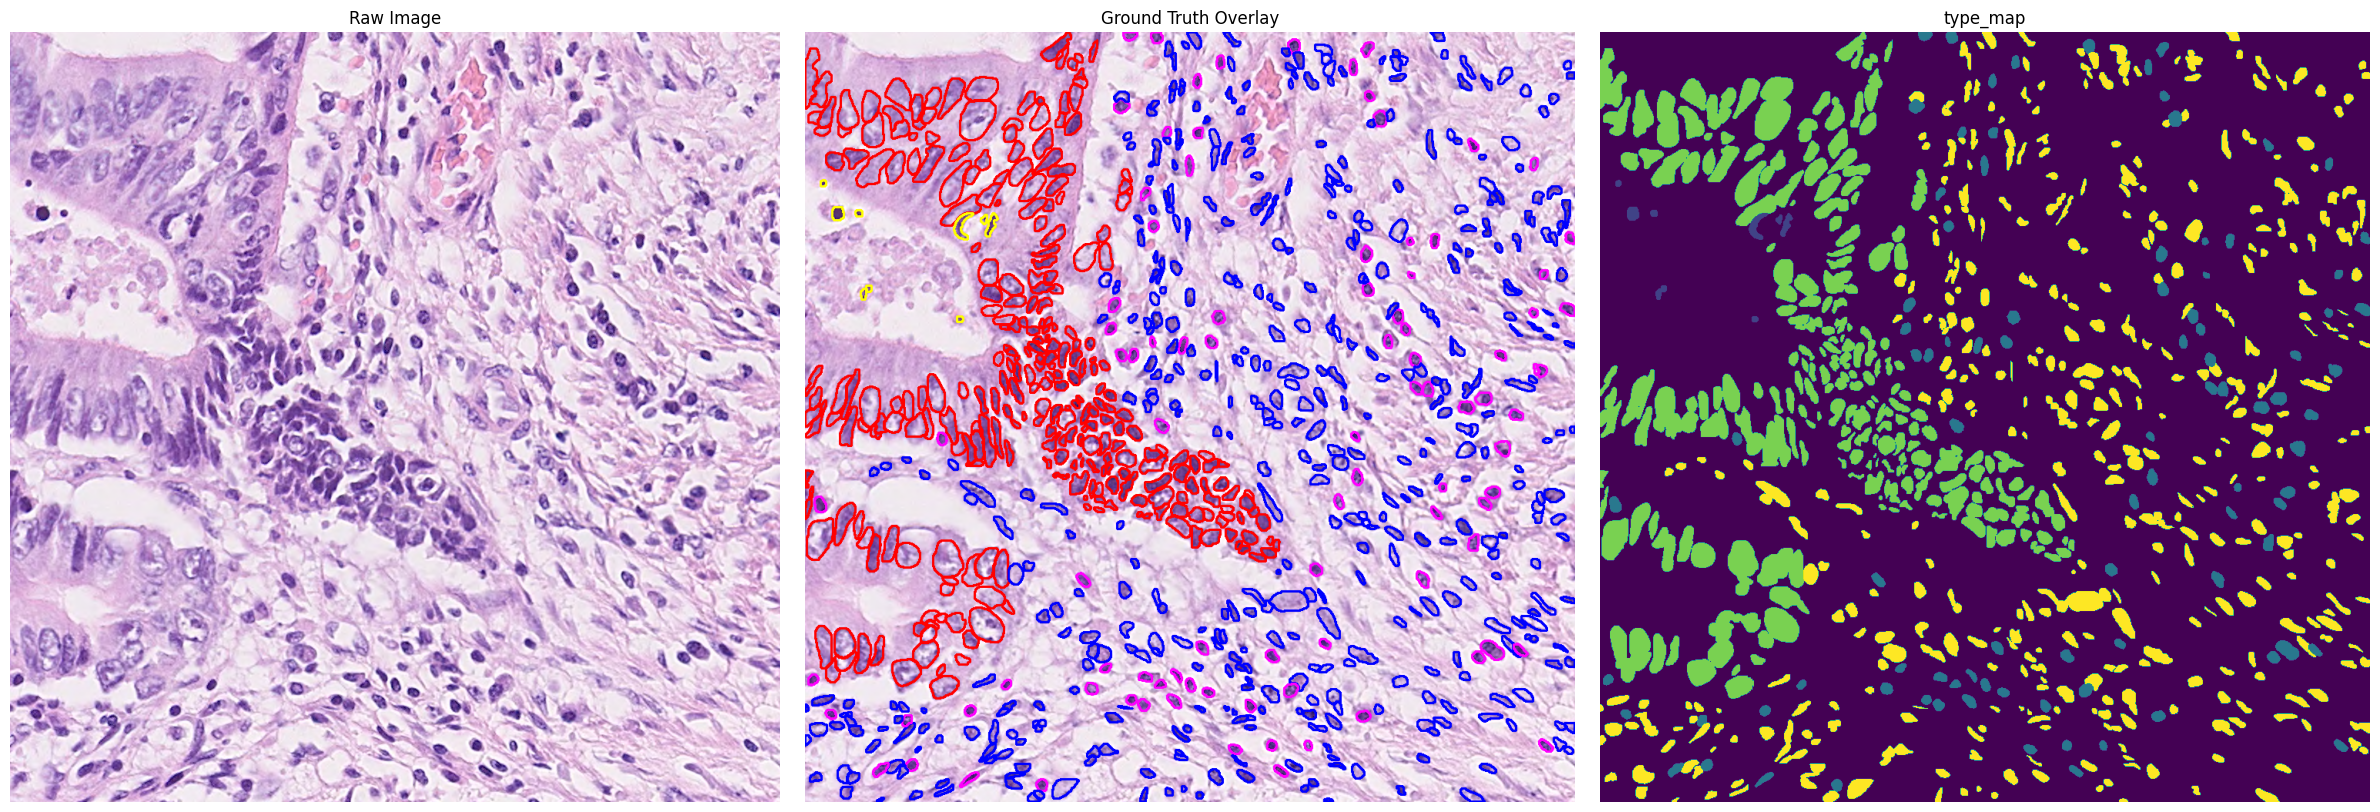

In [13]:
visualize_CoNSeP(data_dir='/workspace/notebook_monai/dataset_hovernet/CoNSeP/', data_type='train', id=1)

### extract patches 
run ./prepare_patches.py to prepare patches from images.
Similar to https://github.com/vqdang/hover_net/blob/master/extract_patches.py

- original data : 1000x1000 pixels
- patch_size : 540x540 pixels
- step size : 164 x 164 

In [14]:
#!python ./prepare_patches.py --root "/workspace/notebook_monai/dataset/CoNSeP" --ps 540 540 --ss 164 164

In [16]:
!ls -lah ./dataset_hovernet/CoNSeP/Prepared/Test

total 3.8G
drwxrwxr-x 2 hryu-nvidia-com hryu-nvidia-com 148K Aug 20 19:08 .
drwxrwxr-x 4 hryu-nvidia-com hryu-nvidia-com 4.0K Aug 20 19:08 ..
-rw-rw-r-- 1 hryu-nvidia-com hryu-nvidia-com 3.4M Aug 20 19:08 test_10_000_image.npy
-rw-rw-r-- 1 hryu-nvidia-com hryu-nvidia-com 1.2M Aug 20 19:08 test_10_000_inst_map.npy
-rw-rw-r-- 1 hryu-nvidia-com hryu-nvidia-com 1.2M Aug 20 19:08 test_10_000_type_map.npy
-rw-rw-r-- 1 hryu-nvidia-com hryu-nvidia-com 3.4M Aug 20 19:08 test_10_001_image.npy
-rw-rw-r-- 1 hryu-nvidia-com hryu-nvidia-com 1.2M Aug 20 19:08 test_10_001_inst_map.npy
-rw-rw-r-- 1 hryu-nvidia-com hryu-nvidia-com 1.2M Aug 20 19:08 test_10_001_type_map.npy
-rw-rw-r-- 1 hryu-nvidia-com hryu-nvidia-com 3.4M Aug 20 19:08 test_10_002_image.npy
-rw-rw-r-- 1 hryu-nvidia-com hryu-nvidia-com 1.2M Aug 20 19:08 test_10_002_inst_map.npy
-rw-rw-r-- 1 hryu-nvidia-com hryu-nvidia-com 1.2M Aug 20 19:08 test_10_002_type_map.npy
-rw-rw-r-- 1 hryu-nvidia-com hryu-nvidia-com 3.4M Aug 20 19:08 test_10_003_

### Set dataset path

In [17]:
def prepare_data(data_dir, phase):
    # prepare datalist
    images = sorted(glob.glob(os.path.join(data_dir, f"{phase}/*image.npy")))
    inst_maps = sorted(glob.glob(os.path.join(data_dir, f"{phase}/*inst_map.npy")))
    type_maps = sorted(glob.glob(os.path.join(data_dir, f"{phase}/*type_map.npy")))

    data_dicts = [
        {"image": _image, "label_inst": _inst_map, "label_type": _type_map}
        for _image, _inst_map, _type_map in zip(images, inst_maps, type_maps)
    ]

    return data_dicts

### Setup transforms for training and validation

Here we use several transforms to augment the dataset:

LoadImaged loads the RGB images and labels from npy format files.
EnsureChannelFirstd ensures the data to construct "channel first" shape.
measure.label generate label instance map.
RandAffined efficiently performs rotate, scale, shear, translate, etc. together based on PyTorch affine transform.
CenterSpatialCropd crop images to input shape.
RandFlipd random flip images.
OneOf randomly choose one transform to smooth images.
TorchVisiond adjust brightness, saturation, contrast and hue based on Torchvision ColorJitter transforms.
ScaleIntensityRanged extracts intensity range [0, 255] and scales to [0, 1].
ComputeHoVerMapsd generate horizontal and vertical distance maps from label instance map.

Note, it is important to select the correct model mode when running inference. 'original' model mode refers to the method described in the original medical image analysis paper with a 270x270 patch input and 80x80 patch output. 'fast' model mode uses a 256x256 patch input and 164x164 patch output. Model checkpoints trained on Kumar, CPM17 and CoNSeP are from  original publication and therefore the 'original' mode must be used. For PanNuke and MoNuSAC, the 'fast' mode must be selected.

in this bootcamp, we will use fast mode for  CoNSeP that means  ROI ( 256,256) and (164,164)

In [18]:
from monai.data import DataLoader, decollate_batch, CacheDataset, Dataset
from monai.apps import download_and_extract
from monai.networks.nets import HoVerNet
from monai.metrics import DiceMetric
from monai.transforms import (
    LoadImaged,
    EnsureChannelFirstd,
    TorchVisiond,
    Lambdad,
    Activations,
    OneOf,
    MedianSmoothd,
    AsDiscrete,
    AsDiscreted,
    Compose,
    CastToTyped,
    ComputeHoVerMapsd,
    ScaleIntensityRanged,
    RandGaussianNoised,
    RandFlipd,
    RandAffined,
    RandGaussianSmoothd,
    CenterSpatialCropd,
)
from monai.apps.pathology.transforms import HoVerNetInstanceMapPostProcessingd, HoVerNetNuclearTypePostProcessingd
from monai.apps.pathology.losses.hovernet_loss import HoVerNetLoss
from monai.apps.pathology.inferers import SlidingWindowHoVerNetInferer

from monai.transforms.utils import apply_transform
from monai.utils import set_determinism, first
from monai.utils.enums import HoVerNetBranch
from monai.visualize import plot_2d_or_3d_image
from skimage import measure
from torch.cuda.amp import GradScaler, autocast

In [19]:
out_classes = 5
train_transforms = Compose(
    [
        LoadImaged(keys=["image", "label_inst", "label_type"], image_only=True),
        EnsureChannelFirstd(keys=["image", "label_inst", "label_type"], channel_dim=-1),
        Lambdad(keys="label_inst", func=lambda x: measure.label(x)),
        RandAffined(
            keys=["image", "label_inst", "label_type"],
            prob=1.0,
            rotate_range=((np.pi), 0),
            scale_range=((0.2), (0.2)),
            shear_range=((0.05), (0.05)),
            translate_range=((6), (6)),
            padding_mode="zeros",
            mode=("nearest"),
        ),
        CenterSpatialCropd(
            keys="image",
            roi_size=(256, 256),
        ),
        RandFlipd(keys=["image", "label_inst", "label_type"], prob=0.5, spatial_axis=0),
        RandFlipd(keys=["image", "label_inst", "label_type"], prob=0.5, spatial_axis=1),
        OneOf(
            transforms=[
                RandGaussianSmoothd(keys=["image"], sigma_x=(0.1, 1.1), sigma_y=(0.1, 1.1), prob=1.0),
                MedianSmoothd(keys=["image"], radius=1),
                RandGaussianNoised(keys=["image"], prob=1.0, std=0.05),
            ]
        ),
        CastToTyped(keys="image", dtype=np.uint8),
        TorchVisiond(
            keys=["image"],
            name="ColorJitter",
            brightness=(229 / 255.0, 281 / 255.0),
            contrast=(0.95, 1.10),
            saturation=(0.8, 1.2),
            hue=(-0.04, 0.04),
        ),
        AsDiscreted(keys=["label_type"], to_onehot=[out_classes]),
        ScaleIntensityRanged(keys=["image"], a_min=0.0, a_max=255.0, b_min=0.0, b_max=1.0, clip=True),
        CastToTyped(keys="label_inst", dtype=torch.int),
        ComputeHoVerMapsd(keys="label_inst"),
        Lambdad(keys="label_inst", func=lambda x: x > 0, overwrite="label"),
        CenterSpatialCropd(
            keys=["label", "hover_label_inst", "label_inst", "label_type"],
            roi_size=(164, 164),
        ),
        AsDiscreted(keys=["label"], to_onehot=2),
        CastToTyped(keys=["image", "label_inst", "label_type"], dtype=torch.float32),
    ]
)
val_transforms = Compose(
    [
        LoadImaged(keys=["image", "label_inst", "label_type"], image_only=True),
        EnsureChannelFirstd(keys=["image", "label_inst", "label_type"], channel_dim=-1),
        Lambdad(keys="label_inst", func=lambda x: measure.label(x)),
        CastToTyped(keys=["image", "label_inst"], dtype=torch.int),
        CenterSpatialCropd(
            keys="image",
            roi_size=(256, 256),
        ),
        ScaleIntensityRanged(keys=["image"], a_min=0.0, a_max=255.0, b_min=0.0, b_max=1.0, clip=True),
        ComputeHoVerMapsd(keys="label_inst"),
        Lambdad(keys="label_inst", func=lambda x: x > 0, overwrite="label"),
        CenterSpatialCropd(
            keys=["label", "hover_label_inst", "label_inst", "label_type"],
            roi_size=(164, 164),
        ),
        CastToTyped(keys=["image", "label_inst", "label_type"], dtype=torch.float32),
    ]
)
infer_transforms = Compose(
    [
        LoadImaged(keys=["image", "label_inst", "label_type"], image_only=True),
        EnsureChannelFirstd(keys=["image", "label_inst", "label_type"], channel_dim=-1),
        Lambdad(keys="label_inst", func=lambda x: measure.label(x)),
        CastToTyped(keys=["image", "label_inst"], dtype=torch.int),
        ScaleIntensityRanged(keys=["image"], a_min=0.0, a_max=255.0, b_min=0.0, b_max=1.0, clip=True),
        ComputeHoVerMapsd(keys="label_inst"),
        CastToTyped(keys=["image", "label_inst", "label_type"], dtype=torch.float32),
    ]
)

### Define CacheDataset and DataLoader for training and validation

Here we use CacheDataset to accelerate training and validation process, it's 10x faster than the regular Dataset. To achieve best performance, set cache_rate=1.0 to cache all the data, if memory is not enough, set lower value. Users can also set cache_num instead of cache_rate, will use the minimum value of the 2 settings. And set num_workers to enable multi-threads during caching.

In [20]:
data_dir = os.path.join(root_dir, "CoNSeP/Prepared/")

### caution !!!

original HoverNet with `batch_size=16` for 16GB GPU memory system.
use less then `batch_size=4`

#### without CacheDataset

In [24]:
batch_size=4

train_data = prepare_data(data_dir, "Train")
valid_data = prepare_data(data_dir, "Test")

train_ds = Dataset(data=train_data, transform=train_transforms )
valid_ds = Dataset(data=valid_data, transform=val_transforms )

train_loader = DataLoader(train_ds, batch_size=batch_size, num_workers=4, shuffle=True, pin_memory=True)
val_loader = DataLoader(valid_ds, batch_size=batch_size, num_workers=4, pin_memory=True)

#### Check first data shape and visualize

image: 
    shape torch.Size([4, 3, 256, 256])
    type:  <class 'monai.data.meta_tensor.MetaTensor'>
    dtype:  torch.float32
label: 
    shape torch.Size([4, 2, 164, 164])
    type:  <class 'monai.data.meta_tensor.MetaTensor'>
    dtype:  torch.float32
hover_label_inst: 
    shape torch.Size([4, 2, 164, 164])
    type:  <class 'monai.data.meta_tensor.MetaTensor'>
    dtype:  torch.float32
train number of batches: 331
valid number of batches: 172


Text(0.5, 1.0, 'raw image')

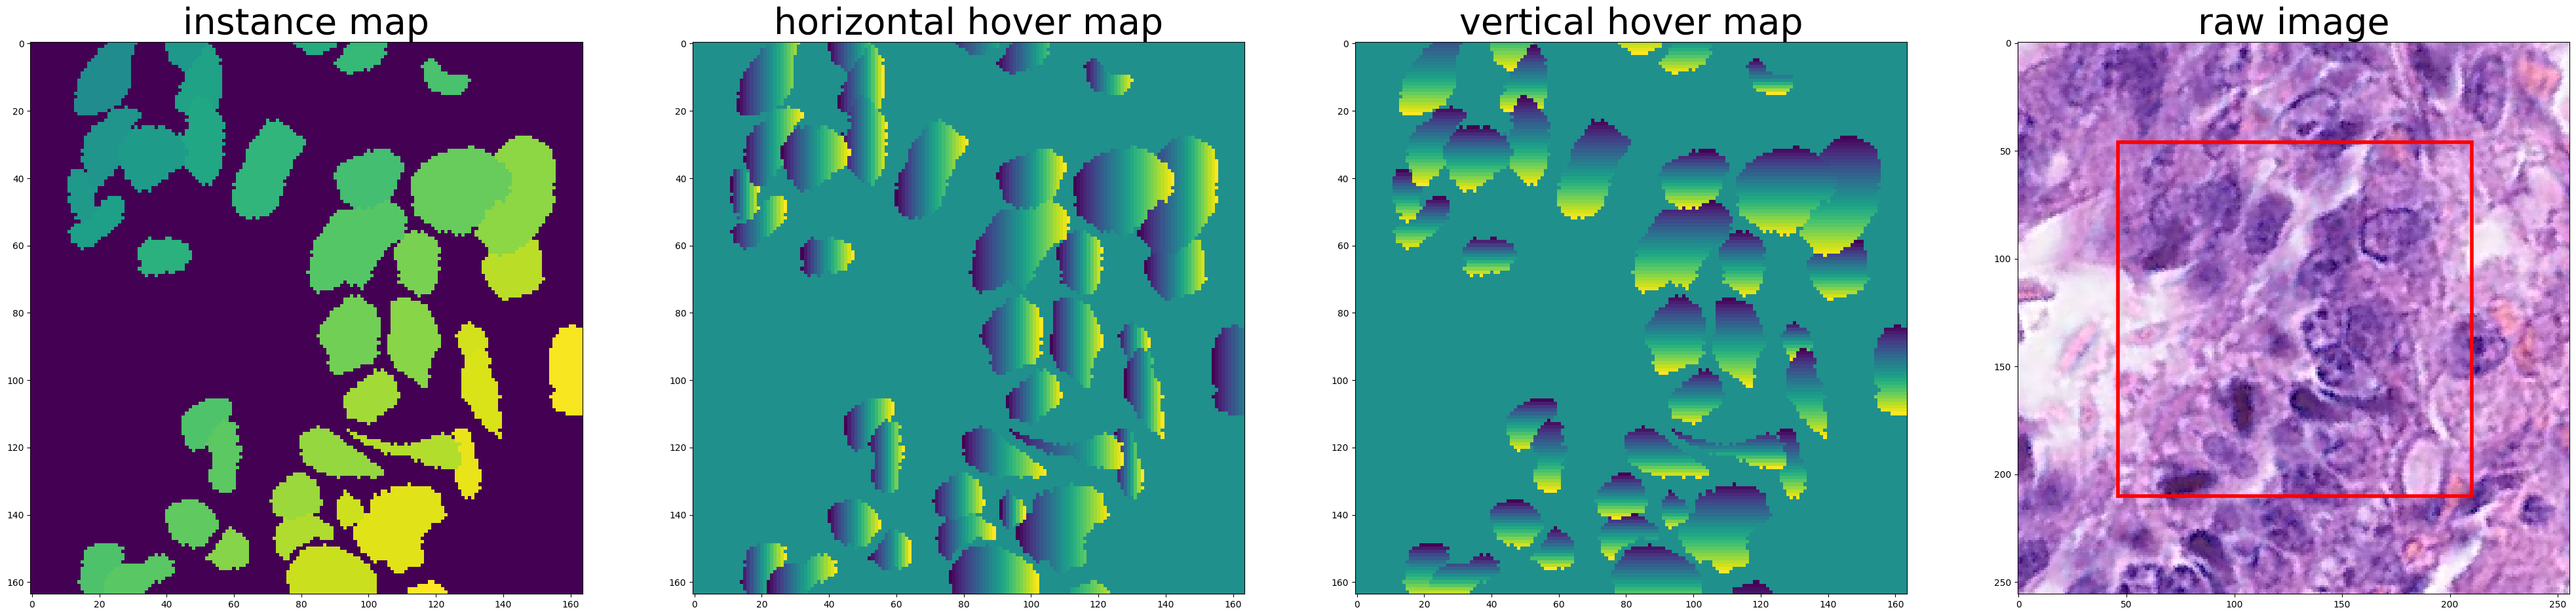

In [25]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

first_sample = first(train_loader)
for k in ("image", "label", "hover_label_inst"):
    print(f"{k}: ")
    print("    shape", first_sample[k].shape)
    print("    type: ", type(first_sample[k]))
    print("    dtype: ", first_sample[k].dtype)
print(f"train number of batches: {len(train_loader)}")
print(f"valid number of batches: {len(val_loader)}")

fig, ax = plt.subplots(1, 4, figsize=(50, 25))
raw_image = (first_sample["image"][0, ...] * 255).astype(np.uint8).transpose(1, 2, 0)

ax[0].imshow(first_sample["label_inst"][0, ...].squeeze())
ax[1].imshow(first_sample["hover_label_inst"][0, 0, ...])
ax[2].imshow(first_sample["hover_label_inst"][0, 1, ...])
ax[3].imshow(raw_image)
ax[3].add_patch(Rectangle((46, 46), 164, 164, fill=False, edgecolor="red", linewidth=4))
ax[0].set_title("instance map", fontsize=40)
ax[1].set_title("horizontal hover map", fontsize=40)
ax[2].set_title("vertical hover map", fontsize=40)
ax[3].set_title("raw image", fontsize=40)

### train HoverNet from scratch

#### Create Model, Loss, Optimizer

HoVerNet is training via a two-stage approach. First initialized the model with pre-trained weights on the ImageNet dataset, trained only the decoders for the first 50 epochs, and then fine-tuned all layers for another 50 epochs. Training used Adam optimizer with an initial learning rate of 10−4 and then reduced it to a rate of 10−5 after 25 epochs. This strategy was repeated for fine-tuning.

Each user is responsible for checking the content of models/datasets and the applicable licenses and determining if suitable for the intended use. The license for the below pre-trained model is different than MONAI license and has been obtained from here: https://github.com/vqdang/hover_net#data-format

### Preact-ResNet50 
HoverNet use pretrained Preact-ResNet50 weights 
We can download the weights [here](https://drive.google.com/file/d/1KntZge40tAHgyXmHYVqZZ5d2p_4Qr2l5/view?usp=sharing) and use local pretrained model. 

- stage 0 : train from ImageNet pretrained model
- stage 1 : train from target dataset (medical image) 
- stage 2 : train from target dataset (medical image) 

In [26]:
# Each user is responsible for checking the content of models/datasets and the applicable licenses and
# determining if suitable for the intended use.
# The license for the below pre-trained model is different than MONAI license.
# Please check the source where these weights are obtained from for the license.
# https://github.com/vqdang/hover_net/blob/master/LICENSE
pretrained_model = "https://drive.google.com/u/1/uc?id=1KntZge40tAHgyXmHYVqZZ5d2p_4Qr2l5&export=download"

In [27]:
def create_model(stage, device):
    if stage == 0:
        model = HoVerNet(
            mode="fast",
            in_channels=3,
            out_classes=out_classes,
            act=("relu", {"inplace": True}),
            norm="batch",
            pretrained_url=pretrained_model,
            freeze_encoder=True,
        ).to(device)
        print(f"stage{stage} start!")
    else:
        model = HoVerNet(
            mode="fast",
            in_channels=3,
            out_classes=out_classes,
            act=("relu", {"inplace": True}),
            norm="batch",
            pretrained_url=None,
            freeze_encoder=False,
        ).to(device)
        model.load_state_dict(torch.load(os.path.join(writer.log_dir, "model_49.pth")))
        print(f"stage{stage}, success load weight!")

    return model



In [30]:
stage = 0
device = torch.device("cuda:0")


model = create_model(stage, device)
loss_function = HoVerNetLoss(lambda_hv_mse=1.0)

# original paper
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.0001, weight_decay=1e-5)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=25)

# lizard dataset
# optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, betas=(0.9, 0.999), weight_decay=0.0)
# lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=25)

dice_metric = DiceMetric(include_background=False, reduction="mean")

2023-08-23 03:17:49,619 - INFO - Expected md5 is None, skip md5 check for file /home/hryu-nvidia-com/.cache/torch/hub/preact-resnet50.pth.
2023-08-23 03:17:49,620 - INFO - File exists: /home/hryu-nvidia-com/.cache/torch/hub/preact-resnet50.pth, skipped downloading.
249 out of 797 keys are updated with pretrained weights.
stage0 start!


### Execute a typical PyTorch training process

Here we use DiceMetric in MONAI to evaluate the performance of segmentation which compute one Dice for each patch and then mean by channel (accounting for nans), then by batch. From original paper which sum the intersection and union areas over the batch dimension before the dividing. Using our pipeline with their metrics. We reproduce the results with Dice: 0.82762; PQ: 0.48976; F1d: 0.73592

In [29]:
amp = True
scaler = GradScaler()
max_epochs = 100 # it takes 1 hours
val_interval = 2

post_process_np = Compose([Activations(softmax=True), AsDiscrete(argmax=True)])
writer = SummaryWriter()

total_start = time.time()
globel_step = 0
epoch_loss_values = []
metric_values = []
for epoch in range(max_epochs):
    if epoch == 50:
        model = create_model(1, device)
        optimizer = torch.optim.Adam(
            filter(lambda p: p.requires_grad, model.parameters()), lr=0.0001, weight_decay=1e-5
        )
        lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=25)
    epoch_start = time.time()
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")

    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step += 1
        globel_step += 1
        inputs, label, label_type, hover_map = (
            batch_data["image"].to(device),
            batch_data["label"].to(device),
            batch_data["label_type"].to(device),
            batch_data["hover_label_inst"].to(device),
        )

        labels = {
            HoVerNetBranch.NP: label,
            HoVerNetBranch.HV: hover_map,
            HoVerNetBranch.NC: label_type,
        }
        optimizer.zero_grad()
        if amp:
            with autocast():
                outputs = model(inputs)
                loss = loss_function(outputs, labels)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            outputs = model(inputs)
            loss = loss_function(outputs, labels)

            loss.backward()
            optimizer.step()

        epoch_loss += loss.item()
        print(f"{step}, train_loss: {loss.item():.4f}")
        writer.add_scalar("train_loss", loss.item(), globel_step)
    lr_scheduler.step()
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        torch.cuda.empty_cache()
        model.eval()
        with torch.no_grad():
            for val_data in val_loader:
                val_inputs, val_label = (
                    val_data["image"].to(device),
                    val_data["label"].to(device),
                )
                with torch.cuda.amp.autocast(enabled=amp):
                    val_outputs = model(val_inputs)

                # hover origin post
                val_outputs = [post_process_np(i[HoVerNetBranch.NP.value]) for i in decollate_batch(val_outputs)]
                val_label = decollate_batch(val_label)

                dice_metric(y_pred=val_outputs, y=val_label)

            metric = dice_metric.aggregate().item()
            dice_metric.reset()

            metric_values.append(metric)
            torch.save(
                model.state_dict(),
                os.path.join(writer.log_dir, f"model_{epoch}.pth"),
            )
            print(f"current epoch: {epoch + 1} current mean dice: {metric:.4f}")
            writer.add_scalar("val_mean_dice", metric, epoch + 1)
            plot_2d_or_3d_image(val_inputs, epoch + 1, writer, index=0, tag="image")
            plot_2d_or_3d_image(val_label, epoch + 1, writer, index=0, tag="label")
            plot_2d_or_3d_image(val_outputs, epoch + 1, writer, index=0, tag="output")

        torch.cuda.empty_cache()

    print(f"time consuming of epoch {epoch + 1} is: {(time.time() - epoch_start):.4f}")
total_time = time.time() - total_start

print(f"train completed, final epoch dice: {metric:.4f} " f"total time: {total_time}")
print("model and log saved in :", writer.log_dir)

----------
epoch 1/100
1, train_loss: 11.1949
2, train_loss: 10.8499
3, train_loss: 10.7037
4, train_loss: 10.4291
5, train_loss: 10.4258
6, train_loss: 9.7190
7, train_loss: 9.9533
8, train_loss: 8.9473
9, train_loss: 8.8794
10, train_loss: 9.2912
11, train_loss: 8.8968
12, train_loss: 8.5348
13, train_loss: 8.0567
14, train_loss: 9.1827
15, train_loss: 7.8902
16, train_loss: 7.7774
17, train_loss: 7.5486
18, train_loss: 7.3239
19, train_loss: 7.8801
20, train_loss: 7.5602
21, train_loss: 6.9328
22, train_loss: 7.0462
23, train_loss: 7.4451
24, train_loss: 8.2828
25, train_loss: 6.7590
26, train_loss: 7.3959
27, train_loss: 6.8305
28, train_loss: 7.2300
29, train_loss: 6.7144
30, train_loss: 7.6445
31, train_loss: 6.5938
32, train_loss: 6.9454
33, train_loss: 6.8244
34, train_loss: 6.4470
35, train_loss: 6.3318
36, train_loss: 6.7650
37, train_loss: 5.7274
38, train_loss: 6.2764
39, train_loss: 6.1788
40, train_loss: 6.4555
41, train_loss: 6.0229
42, train_loss: 6.7546
43, train_loss:

KeyboardInterrupt: 

### Plot the loss and metric

In [ ]:

plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.show()

### Check best model output with the input image and label



In [ ]:
# shuffle the instance id of the instance map for better visualisation
def shuffle_inst_map_id(instance_map):
    instance_id = list(np.unique(instance_map)[1:])  # exclude background
    new_instance_id = np.random.permutation(instance_id)
    new_instance_map = np.zeros(instance_map.shape)
    for i, _instance_id in enumerate(instance_id):
        new_instance_map[instance_map == _instance_id] = new_instance_id[i]
    return new_instance_map

In [ ]:
post_transforms = Compose(
    [
        HoVerNetInstanceMapPostProcessingd(sobel_kernel_size=21, marker_threshold=0.4, marker_radius=2),
        HoVerNetNuclearTypePostProcessingd(),
    ]
)

In [ ]:

# test postprocess transform
model.load_state_dict(torch.load(os.path.join(writer.log_dir, "model_99.pth")))


In [ ]:
model.eval()
with torch.no_grad():
    # select one image to evaluate and visualize the model output
    valid_ds = Dataset(data=valid_data[:10], transform=infer_transforms)
    val_data = valid_ds[5]
    val_input = val_data["image"].unsqueeze(0).to(device)

    sliding_inferer = SlidingWindowHoVerNetInferer(
        roi_size=256,
        sw_batch_size=8,
        overlap=1.0 - float(164) / float(256),
        padding_mode="constant",
        cval=0,
        sw_device=device,
        device=device,
        progress=True,
        extra_input_padding=((256 - 164) // 2,) * 4,
    )
    val_output = sliding_inferer(val_input, model)
    val_output_ = [apply_transform(post_transforms, i) for i in decollate_batch(val_output)]

    label_inst_map = shuffle_inst_map_id(val_data["label_inst"].squeeze().detach().cpu().numpy())
    pred_inst_map = shuffle_inst_map_id(val_output_[0]["instance_map"].squeeze())

    fig, ax = plt.subplots(2, 4, figsize=(80, 40))
    ax[0, 0].imshow(label_inst_map)
    ax[0, 1].imshow(val_data["label_type"].squeeze().detach().cpu())
    ax[0, 2].imshow(val_data["hover_label_inst"][0, ...].detach().cpu())
    ax[0, 3].imshow(val_data["hover_label_inst"][1, ...].detach().cpu())

    ax[1, 0].imshow(pred_inst_map)
    ax[1, 1].imshow(val_output_[0]["type_map"].squeeze())
    ax[1, 2].imshow(val_output[HoVerNetBranch.HV.value].detach().cpu().squeeze()[0, ...])
    ax[1, 3].imshow(val_output[HoVerNetBranch.HV.value].detach().cpu().squeeze()[1, ...])

    ax[0, 0].set_title("instance map", fontsize=60)
    ax[0, 1].set_title("type map", fontsize=60)
    ax[0, 2].set_title("horizontal hover map", fontsize=60)
    ax[0, 3].set_title("vertical hover map", fontsize=60)
    ax[1, 0].set_title("pred instance map", fontsize=60)
    ax[1, 1].set_title("pred type map", fontsize=60)
    ax[1, 2].set_title("pred horizontal hover map", fontsize=60)
    ax[1, 3].set_title("pred vertical hover map", fontsize=60)

# Assessment - compare train time with CacheDataset

In [ ]:
## with CacheDataset

In [ ]:
batch_size=4

train_data = prepare_data(data_dir, "Train")
valid_data = prepare_data(data_dir, "Test")

train_ds = CacheDataset(data=train_data, transform=train_transforms, cache_rate=1.0, num_workers=4)
valid_ds = CacheDataset(data=valid_data, transform=val_transforms, cache_rate=1.0, num_workers=4)

train_loader = DataLoader(train_ds, batch_size=batch_size, num_workers=4, shuffle=True, pin_memory=True)
val_loader = DataLoader(valid_ds, batch_size=batch_size, num_workers=4, pin_memory=True)

In [ ]:
stage = 0
device = torch.device("cuda:0")


model = create_model(stage, device)
loss_function = HoVerNetLoss(lambda_hv_mse=1.0)

# original paper
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.0001, weight_decay=1e-5)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=25)

# lizard dataset
# optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, betas=(0.9, 0.999), weight_decay=0.0)
# lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=25)

dice_metric = DiceMetric(include_background=False, reduction="mean")

In [ ]:
amp = True
scaler = GradScaler()
max_epochs = 100
val_interval = 2

post_process_np = Compose([Activations(softmax=True), AsDiscrete(argmax=True)])
writer = SummaryWriter()

total_start = time.time()
globel_step = 0
epoch_loss_values = []
metric_values = []
for epoch in range(max_epochs):
    if epoch == 50:
        model = create_model(1, device)
        optimizer = torch.optim.Adam(
            filter(lambda p: p.requires_grad, model.parameters()), lr=0.0001, weight_decay=1e-5
        )
        lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=25)
    epoch_start = time.time()
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")

    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step += 1
        globel_step += 1
        inputs, label, label_type, hover_map = (
            batch_data["image"].to(device),
            batch_data["label"].to(device),
            batch_data["label_type"].to(device),
            batch_data["hover_label_inst"].to(device),
        )

        labels = {
            HoVerNetBranch.NP: label,
            HoVerNetBranch.HV: hover_map,
            HoVerNetBranch.NC: label_type,
        }
        optimizer.zero_grad()
        if amp:
            with autocast():
                outputs = model(inputs)
                loss = loss_function(outputs, labels)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            outputs = model(inputs)
            loss = loss_function(outputs, labels)

            loss.backward()
            optimizer.step()

        epoch_loss += loss.item()
        print(f"{step}, train_loss: {loss.item():.4f}")
        writer.add_scalar("train_loss", loss.item(), globel_step)
    lr_scheduler.step()
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        torch.cuda.empty_cache()
        model.eval()
        with torch.no_grad():
            for val_data in val_loader:
                val_inputs, val_label = (
                    val_data["image"].to(device),
                    val_data["label"].to(device),
                )
                with torch.cuda.amp.autocast(enabled=amp):
                    val_outputs = model(val_inputs)

                # hover origin post
                val_outputs = [post_process_np(i[HoVerNetBranch.NP.value]) for i in decollate_batch(val_outputs)]
                val_label = decollate_batch(val_label)

                dice_metric(y_pred=val_outputs, y=val_label)

            metric = dice_metric.aggregate().item()
            dice_metric.reset()

            metric_values.append(metric)
            torch.save(
                model.state_dict(),
                os.path.join(writer.log_dir, f"model_{epoch}.pth"),
            )
            print(f"current epoch: {epoch + 1} current mean dice: {metric:.4f}")
            writer.add_scalar("val_mean_dice", metric, epoch + 1)
            plot_2d_or_3d_image(val_inputs, epoch + 1, writer, index=0, tag="image")
            plot_2d_or_3d_image(val_label, epoch + 1, writer, index=0, tag="label")
            plot_2d_or_3d_image(val_outputs, epoch + 1, writer, index=0, tag="output")

        torch.cuda.empty_cache()

    print(f"time consuming of epoch {epoch + 1} is: {(time.time() - epoch_start):.4f}")
total_time = time.time() - total_start

print(f"train completed, final epoch dice: {metric:.4f} " f"total time: {total_time}")
print("model and log saved in :", writer.log_dir)

In [ ]:

plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.show()

In [ ]:

# test postprocess transform
model.load_state_dict(torch.load(os.path.join(writer.log_dir, "model_99.pth")))


In [ ]:
model.eval()
with torch.no_grad():
    # select one image to evaluate and visualize the model output
    valid_ds = Dataset(data=valid_data[:10], transform=infer_transforms)
    val_data = valid_ds[5]
    val_input = val_data["image"].unsqueeze(0).to(device)

    sliding_inferer = SlidingWindowHoVerNetInferer(
        roi_size=256,
        sw_batch_size=8,
        overlap=1.0 - float(164) / float(256),
        padding_mode="constant",
        cval=0,
        sw_device=device,
        device=device,
        progress=True,
        extra_input_padding=((256 - 164) // 2,) * 4,
    )
    val_output = sliding_inferer(val_input, model)
    val_output_ = [apply_transform(post_transforms, i) for i in decollate_batch(val_output)]

    label_inst_map = shuffle_inst_map_id(val_data["label_inst"].squeeze().detach().cpu().numpy())
    pred_inst_map = shuffle_inst_map_id(val_output_[0]["instance_map"].squeeze())

    fig, ax = plt.subplots(2, 4, figsize=(80, 40))
    ax[0, 0].imshow(label_inst_map)
    ax[0, 1].imshow(val_data["label_type"].squeeze().detach().cpu())
    ax[0, 2].imshow(val_data["hover_label_inst"][0, ...].detach().cpu())
    ax[0, 3].imshow(val_data["hover_label_inst"][1, ...].detach().cpu())

    ax[1, 0].imshow(pred_inst_map)
    ax[1, 1].imshow(val_output_[0]["type_map"].squeeze())
    ax[1, 2].imshow(val_output[HoVerNetBranch.HV.value].detach().cpu().squeeze()[0, ...])
    ax[1, 3].imshow(val_output[HoVerNetBranch.HV.value].detach().cpu().squeeze()[1, ...])

    ax[0, 0].set_title("instance map", fontsize=60)
    ax[0, 1].set_title("type map", fontsize=60)
    ax[0, 2].set_title("horizontal hover map", fontsize=60)
    ax[0, 3].set_title("vertical hover map", fontsize=60)
    ax[1, 0].set_title("pred instance map", fontsize=60)
    ax[1, 1].set_title("pred type map", fontsize=60)
    ax[1, 2].set_title("pred horizontal hover map", fontsize=60)
    ax[1, 3].set_title("pred vertical hover map", fontsize=60)

## Navigation

- [01 MONAI transform](./01_getting.ipynb)
- [02_end_to_end_pipeline](./02_end_to_end_pipeline.ipynb)
- [03_spleen_segment](./03_spleen_segment.ipynb)
- [04_Auto3DSeg](./04_Auto3DSeg.ipynb)
- [05_Auto3DSeg_hippocampus](./05_Auto3DSeg_hippocampus.ipynb)
- [06_digital_pathology_wsi](./06_digital_pathology_wsi.ipynbb)
- [07_HoverNet_01_inference](./07_HoverNet_01_inference.ipynb)
- [08_HoverNet_02_train](./08_HoverNet_02_train.ipynb)



<img src="https://github.com/Project-MONAI/MONAIBootcamp2021/raw/2f28b64f814a03703667c8ea18cc84f53d6795e4/day1/monai.png" width=400>